# توجه 

1. به راهنمایی هایی که در کد آمده است توجه کنید
2. مواردی که به صورت "#TODO"
را باید بصورتی که در صورت پروژه تعریف شده است انجام دهید. 

In [ ]:
! pip install parsivar
! pip install gensim==4.1.2
!pip install words
!pip install elasticsearch
!pip install pandas
!pip install sklearn
!pip install openpyxl

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from parsivar import Normalizer, Tokenizer, FindStems
import json
from tqdm import tqdm
from gensim.models import Word2Vec
from string import punctuation
import numpy as np
import re
import random
import pandas as pd
# import whatever you need for your implementation  

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Download Datasets

In [ ]:
!gdown --id 1ea3SbNwRZATzlTpTI6L7eQ73W40APj5G

In [ ]:
!gdown --id 15v9oRRhC0Eo8q2RTkQUXw72tA0TjMSQb

In [ ]:
!gdown --id 14c814CDp7aDQQOiqqCcMWI9GvZps8JIt

# step 1 
داده هایی که در اختیار دارید را بارگذاری کنید و مشابه بخش های قبل پیش پردازش های لازم را انجام دهید. 
مطابق فازهای و بخش های پیشین پروژه مراحل پیش پردازش را انجام دهید. در نهایت لیست از اسناد بسازید که برای هر متن شامل توکن های آن متن باشد. 
این لیست میتواند ساختاری مطابق تصویر زیر داشته باشد.
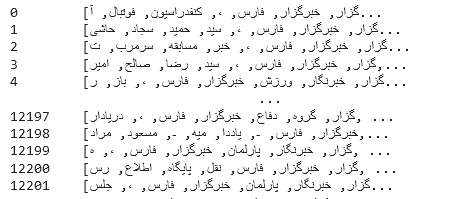

In [6]:
# import data in json format
file_name = 'IR_data_news_12k.json'
def load_docs(file_name):
    with open(file_name) as f:
        data = json.load(f)
    return data

In [7]:
stopwords_remove = True
stemming = True

In [8]:
def load_stopwords(stopwords_path):
    stopwords_set = None
    with open(stopwords_path, 'r') as f:
        stopwords_set = set(f.read().split())
    return stopwords_set

def remove_stopwords(words, persian_stopwords_path='./persian-stopwords.txt'):
    persian_stopwords = load_stopwords(persian_stopwords_path)
    return [word for word in words if word not in persian_stopwords]

In [9]:
def preprocess(text, stopwords_remove=True, stemming=True):
    normalizer = Normalizer()
    tokenizer = Tokenizer()
    stemmer = FindStems()
    
    pure_text = re.sub(f'[{punctuation}؟،٪×÷»«]+', '', text)
    normal_text = normalizer.normalize(pure_text)
    res = tokenizer.tokenize_words(normal_text)
    if stemming:
        res = list(map(stemmer.convert_to_stem, res))
    if stopwords_remove:
        res = remove_stopwords(res)
    
    return res

print(preprocess('سلام من امروز می خواهم این تابع را ۳ بار امتحان کنم.', stopwords_remove=stopwords_remove, stemming=stemming))

['سلام', 'امروز', 'خواست&خواه', 'تابع', '3', 'امتحان', 'کرد&کن']


In [10]:
def preprocess_contents(docs_dict, stopwords_remove=True, stemming=True):
    
    for docID, body in docs_dict.items():
        body['content'] = preprocess(body['content'], stopwords_remove, stemming)
        
    return docs_dict

preprocessed_docs = preprocess_contents(load_docs(file_name), stopwords_remove=stopwords_remove, stemming=stemming)

In [11]:
dataset = [doc['content'] for docID, doc in preprocessed_docs.items()]

# گام دوم 
در این گام شما باید بتوانید که هر سند را به یک بردار عددی تبدیل کنید. این کار را به کمک ماژول آماده ایی که در اختیار شما قرار گرفته است انجام می شود.
بدین منظور مراحل زیر را انجام دهید. 










دو بلوک بعدی کد برای استفاده از ماژول آماده تهیه شده و صرفا به شکل مثال نوشته شده اند، ممکن است برای استفاده عملی در پروژه نیاز به تغییر باشد. 

In [12]:
from  embeding import * 
# dataset: each document is a list of its tokens. 
# model_path: is a path that you want save model in it. 
doc2vec = DocToVec(dataset , vec_size = 200 , model_path = 'word2vec.model')


Loading the model ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



تولید بردارهای تمام اسناد و ذخیره در یک لیست بمنظور استفاده در گام های بعدی 

In [13]:
%%time
doc_vectors = []
for i in tqdm(range(len(dataset))):
  doc_vectors.append(doc2vec.embed(dataset[i])) 

100%|██████████| 12202/12202 [00:35<00:00, 341.00it/s]

CPU times: user 35.4 s, sys: 656 ms, total: 36.1 s
Wall time: 35.8 s


# ابتدا بردارهای عددی داده های تست را بدست آورده و سپس از این بردارها برای تولید بردار  بقیه ی داده ها استفاده کنید. 

In [14]:
mapping = { 
    "mappings": {
        "properties": {
          "content": {
            "type": "text"
          },
            "category":{
                "type": "keyword"
            },
            "vec":{
                "type": "dense_vector",
                "dims": 200,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

In [15]:
!echo -e "[ELASTIC]\ncloud_id = IR_phase3:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDE4MDM5N2JjM2YyMTRjMzVhYzFmMjgzYjNmM2ZkYzk1JDYwNmE4YzY5ZmM5MjQ0ZGQ4MGRhZDdhODk1OTI0YzNl\nuser = elastic\npassword = Dq9uLcCHKbnsqXMQtASef5z0\n" > example.ini

In [16]:
!cat example.ini

[ELASTIC]
cloud_id = IR_phase3:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDE4MDM5N2JjM2YyMTRjMzVhYzFmMjgzYjNmM2ZkYzk1JDYwNmE4YzY5ZmM5MjQ0ZGQ4MGRhZDdhODk1OTI0YzNl
user = elastic
password = Dq9uLcCHKbnsqXMQtASef5z0



In [17]:
import configparser

config = configparser.ConfigParser()
config.read('example.ini')

['example.ini']

In [18]:
# Here we try to connect to Elastic
es = Elasticsearch(
    cloud_id=config['ELASTIC']['cloud_id'],
    http_auth=(config['ELASTIC']['user'], config['ELASTIC']['password'])
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  after removing the cwd from sys.path.


In [19]:
index_name = 'ir_knn'

In [20]:
# Delete index if one does exist
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# Create index
es.indices.create(index=index_name, body=mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_knn'})

In [21]:
data = pd.read_excel('IR01_3_test_4k.xlsx').dropna()
data = data.to_dict()
print(list(data.keys()))

['Unnamed: 0', 'content', 'category', 'url']


In [22]:
from copy import deepcopy
data_tmp = []
for i in tqdm(range(len(data['content']))):
    tmp_doc = data
    doc = dict()
    if tmp_doc['content'][i] == 'content':
      continue
    preprocess_content = preprocess(tmp_doc['content'][i])
    # filter_doc: method for preprocessing a doc. 
    doc['content'] = " ".join(preprocess_content)
    doc['vec'] = list(doc2vec.embed(preprocess_content))
    doc['category'] = tmp_doc['category'][i]
    data_tmp.append(doc)


100%|██████████| 4022/4022 [01:23<00:00, 48.43it/s]


In [ ]:
print(data_tmp[15]['content'])
print(data_tmp[15]['vec'])
print(data_tmp[15]['category'])  

In [24]:
data_bulk = [
    {
        "_index" : index_name,
        "_id" : i + 1,
        "_source": data_tmp[i]
    }
    for i in range(len(data_tmp))
]
resp = helpers.bulk(
  es,
  data_bulk,
  index = index_name
)
print(resp)

(4021, [])


# گام سوم

در این بخش باید داده های تست را بارگذاری و پیش پردازش کنید و سپس برای هر متن بردار آن را بدست آورده و به روش  نزدیکترین همسایه جستجو را انجام داده و برچسب این سند را بدست آورید. 

In [25]:
test_dataset = pd.read_excel("IR01_3_46k.xlsx")

In [ ]:
res = []
for i in tqdm(range(len(test_dataset))):
    vec = doc2vec.embed(preprocess(test_dataset.content[i]))
    try:
        resp = es.knn_search(index=index_name,knn={
          #  TODO
          "field": "vec",
          "query_vector": vec,
          "k": 5,
          "num_candidates": 100
        }
          ,source=['content','category'],)
        res.append(resp)
      #  predict label for doc
      # TODO
    except:
        # usualy happens when all the elements of 
        # the vector are zero.
        res.append(None)

In [134]:
res[27000]['hits']['hits'][0]["_source"]['category']

'health'

In [104]:
def most_frequent_member(input_list):
  # print(input_list)
  return max(input_list, key=input_list.count)

def get_category(docID, query_res):
  categories = list(map(lambda x: x['_source']['category'], query_res[docID]['hits']['hits']))
  return most_frequent_member(categories)

print(get_category(323, res))

sport


# گام چهارم 

حال که برای هر متن برچسب آن را بدست آورده اید. متون هر دسته را به نحوی از سایر دسته ها مجزا کنید و مطابق موارد خواسته شده در گزارش جستجو را در دسته های مختلف انجام دهید. 

In [96]:
index_name_v2 = 'ir_knn_v2'

In [97]:
# Delete index if one does exist
if es.indices.exists(index=index_name_v2):
    es.indices.delete(index=index_name_v2)

# Create index
es.indices.create(index=index_name_v2, body=mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_knn_v2'})

In [ ]:
from copy import deepcopy
data_tmp_v2 = []
for i in tqdm(range(len(test_dataset))):
  try:
      tmp_doc = test_dataset
      doc = dict()
      if tmp_doc['content'][i] == 'content':
        continue
      preprocess_content = preprocess(tmp_doc.content[i])
      # filter_doc: method for preprocessing a doc. 
      doc['content'] = " ".join(preprocess_content)
      doc['vec'] = list(doc2vec.embed(preprocess_content))
      doc['category'] = get_category(i, res)
      data_tmp_v2.append(doc)
  except:
    pass

In [98]:
data_bulk_v2 = [
    {
        "_index" : index_name_v2,
        "_id" : i + 1,
        "_source": data_tmp_v2[i]
    }
    for i in range(len(data_tmp_v2))
]
resp_v2 = helpers.bulk(
  es,
  data_bulk_v2,
  index = index_name_v2
)
print(resp_v2)

(46447, [])


In [141]:
def knn_query_search(query, category):
    vec = doc2vec.embed(preprocess(query))
    try:
        resp = es.knn_search(index=index_name_v2,knn={
          #  TODO
          "field": "vec",
          "query_vector": vec,
          "k": 5,
          "num_candidates": 100
        }
          ,source=['content','category'])
        if resp:
            hit_list = resp['hits']['hits']
            final_res = [x for x in hit_list]
            if len(final_res) > 0:
              for res in final_res:
                print(f'DocID: [{res["_id"]}]')
                print(f'Score: [{res["_score"]}]')
                print(f'Category: [{res["_source"]["category"]}]')
                print(f'Content: \n{test_dataset.content[int(res["_id"])]}')
                print(50*'-')
        #  predict label for doc
        # TODO
    except:
        # usualy happens when all the elements of 
        # the vector are zero.
        pass

In [142]:
example_query1 = 'نتایج مسابقات لیگ برتر فوتبال ایران'
example_category1 = 'sport'
knn_query_search(example_query1, example_category1)

DocID: [12460]
Score: [0.8789513]
Category: [sport]
Content: 
به گزارش خبرگزاری فارس، تیم فوتبال پاس همدان در مرحله یک شانزدهم جام حذفی
انصراف داد و حاضر به سفر به شهر جم و مسابقه با تیم پارس جنوبی نشد.

به این ترتیب پرونده این باشگاه از سوی سازمان لیگ فوتبال ایران به کمیته انضباطی
فدراسیون ارسال می شود تا در مورد کناره‌گیری پاس همدان تصمیم‌های قانونی اتخاذ
شود.

انتهای پیام/ ش


--------------------------------------------------
DocID: [17083]
Score: [0.8772552]
Category: [sport]
Content: 
به گزارش خبرگزاری فارس، بعدازظهر امروز مجتبی فریدونی مدیرعامل جدید باشگاه ذوب
آهن اصفهان ضمن حضور در محل تمرین تیم فوتبال، با رحمان رضایی، اعضای کادر فنی و
بازیکنان دیدار و گفت‌وگو کرد.

فریدونی با ابراز خرسندی از حضور در جمع کادر فنی و بازیکنان تیم فوتبال ذوب آهن
عنوان کرد: همه ما همدل شده ایم تا تیم بهترین نتایج را کسب کند. در کمال آرامش و
تمرکز بر مسائل فنی تلاش کنید و نگران هیچ چیز نباشید. هیات مدیره کارخانه،
مدیرعامل شرکت، هیات مدیره و همه عوامل و دست اندرکاران باشگاه به همراه
هواداران، یکدل و 

<div dir="rtl">
  در 5 داک برگردانده شده، تنها از لحاظ فوتبالی بودن داک اول، دوم و چهارم مربوط بوده اند. البته باید توجه داشت که داک چهارم مربوط به فوتبال لیگ ایتالیا می باشد. داک سوم و پنجم در میان این داک ها از نوع ورزش بسکتبال بوده و ارتباط معنایی زیادی با فوتبال دارا نمی باشد.
</div>

In [143]:
example_query2 = 'نوسانات قیمت دلار در بازار آزاد'
example_category2 = 'economy'
knn_query_search(example_query2, example_category2)

DocID: [29662]
Score: [0.929139]
Category: [economy]
Content: 
به گزارش گروه اقتصاد بین الملل خبرگزاری فارس، هند پس از اینکه کشورهای اوپک
درخواست مقامات این کشور برای عرضه نفت بیشتر را رد کردند به دنبال راههایی برای
کاهش وابستگی به نفت خاورمیانه هستند.

هند تلاش می کند تا منابع جدیدی را برای تامین نفت مورد نیاز کشور پیدا
کند.آمارهای «ریفینیتیو ایکون» نشان میدهد که هند نخستین محموله نفتی خود را از
گایانا خریداری کرده که این محموله از سواحل آمریکای جنوبی به مقصد هند خارج شده
است.

طبق برنامه ریزی ها نفتی که هند از گایانا خریداری کرده یک میلیون بشکه است و 8
آوریل به بندر ماندار هند وارد خواهد شد.

گایانا با نام رسمی جمهوری تعاونی گویان کشوری در شمال شرقی آمریکای جنوبی در
منطقه کارائیب است. پایتخت آن جورج‌تاون و جمعیت آن در حدود ۷۸۷ هزار نفر
است.زبان رسمی این کشور انگلیسی و واحد پول آن دلار گویان است. گایانا از شرق با
سورینام، از جنوب با برزیل و از غرب با ونزوئلا و با اقیانوس اطلس هم‌مرز است.
گایانا با ۲۱۵,۰۰۰ کیلومتر مربع، بعد از اروگوئه و سورینام کوچکترین کشور آمریکای
جنوبی است.

هند سوم

<div dir="rtl">
  در این قسمت، هیچکدام از داک های برگردانده شده به طور مستقیم مربوط به موضوع نوسانات قیمت دلار در بازار آزاد نمی باشد اما کلیت موضوع مورد بحث در رابطه با قیمت و دلار می باشد. نامربوط ترین داک برگردانده شده داک دوم است که در رابطه با باطل شدن پرواز استانبول - تهران می باشد که ارتباط موضوعی کمتری با موضوع دلار و قیمت ها داراست.
</div>

In [144]:
example_query3 = 'تزریق دوز تقویتی واکسن کرونا'
example_category3 = 'health'
knn_query_search(example_query3, example_category3)

DocID: [28906]
Score: [0.92654735]
Category: [health]
Content: 
به گزارش خبرگزاری فارس، رئیس اتحادیه دام سبک در مجموعه کرسی‌های کشاورزی ۱۴۰۰
که از سوی [بسیج دانشجویی](https://search.farsnews.ir/?q=بسیج دانشجویی&o=on)
پردیس ابوریحان دانشگاه تهران برگزار شد، گفت: هر ساله بخش صنعت اولویت مناظره
کاندیدا‌های ریاست جمهوری بوده؛ با این وجود امیدواریم که امسال کاندیدا‌ها
برنامه‌های خود در حوزه کشاورزی را نیز اعلام کنند.

وی افزود: سالیان طولانی است که بخش کشاورزی ما تولید کرده و مردم بدون دغدغه این
تولیدات را مصرف کرده اند، ولی واقعیت این است که منابع آب و خاک کشور محدود
هستند؛ بنابراین ما باید با توجه به این محدودیت‌ها به برنامه ریزی بپردازیم و
توجه داشته باشیم که بخش کشاورزی در حوزه دام، زراعت و باغ با بهره وری پایینی
روبرو است.  
  
دادرس با تاکید بر اینکه دولت آینده باید بهره وری در بخش کشاورزی را مورد توجه
قرار دهد، افزود: یکی از مهمترین مشکلات ما در بخش کشاورزی این است که برنامه‌های
سالانه و یا برنامه‌های پنج ساله توسعه عملیاتی و قابل اجرا نیستند و صرفا روی
کاغذ نوشته می‌شوند با این وجود

<div dir="rtl">
در این قسمت، هیچ یک از چهار داک ابتدایی مرتبط با موضوع کرونا نمی باشد و تنها آخرین داک است که به کرونا مربوط است اما در این داک نیز صحبتی از واکسن یا واکسیناسیون نشده است. همانطور که در 4 داک اول مشاهده می شود، این داک ها به اشتباه لیبل خورده اند. چرا که این داک ها شباهت بیشتری با موضوعات سیاسی و اقتصادی دارند و ارتباط آن چنانی با موضوع سلامت ندارند.
</div>